In [1]:
# Install required libraries
!pip install scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
column_names = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df = pd.read_csv(url, names=column_names)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nMissing values:\n{df.isnull().sum().sum()}")
print(f"\nTarget distribution:\n{df['diagnosis'].value_counts()}")

Dataset shape: (569, 32)

First few rows:
         id diagnosis  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    842302         M      17.99      10.38     122.80     1001.0    0.11840   
1    842517         M      20.57      17.77     132.90     1326.0    0.08474   
2  84300903         M      19.69      21.25     130.00     1203.0    0.10960   
3  84348301         M      11.42      20.38      77.58      386.1    0.14250   
4  84358402         M      20.29      14.34     135.10     1297.0    0.10030   

   feature_6  feature_7  feature_8  ...  feature_21  feature_22  feature_23  \
0    0.27760     0.3001    0.14710  ...       25.38       17.33      184.60   
1    0.07864     0.0869    0.07017  ...       24.99       23.41      158.80   
2    0.15990     0.1974    0.12790  ...       23.57       25.53      152.50   
3    0.28390     0.2414    0.10520  ...       14.91       26.50       98.87   
4    0.13280     0.1980    0.10430  ...       22.54       16.67      152.20   

  

In [3]:
# Remove ID column
df = df.drop('id', axis=1)

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
feature_columns = df.columns[1:]
df[feature_columns] = imputer.fit_transform(df[feature_columns])

# Encode target variable
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Preprocessing completed!")
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")

Preprocessing completed!
Features shape: (569, 30)
Target shape: (569,)


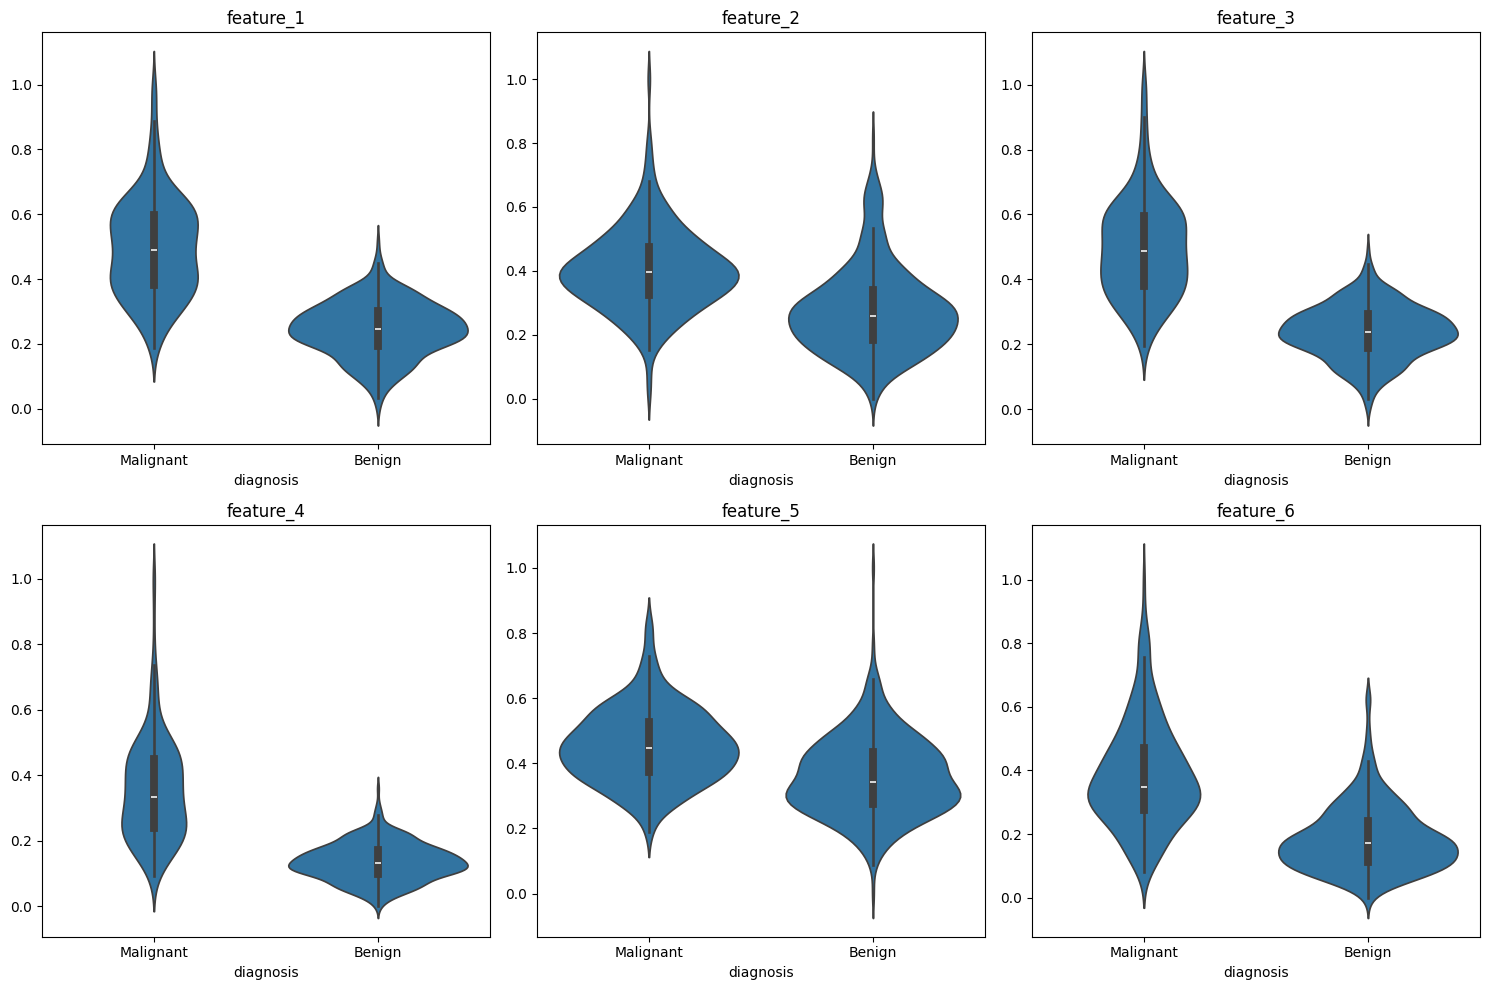

In [4]:
# Violin plots for selected features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

sample_features = X_scaled.columns[:6]
for idx, feature in enumerate(sample_features):
    data_to_plot = pd.DataFrame({
        'value': X_scaled[feature],
        'diagnosis': y.map({0: 'Benign', 1: 'Malignant'})
    })
    sns.violinplot(data=data_to_plot, x='diagnosis', y='value', ax=axes[idx])
    axes[idx].set_title(f'{feature}')
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()

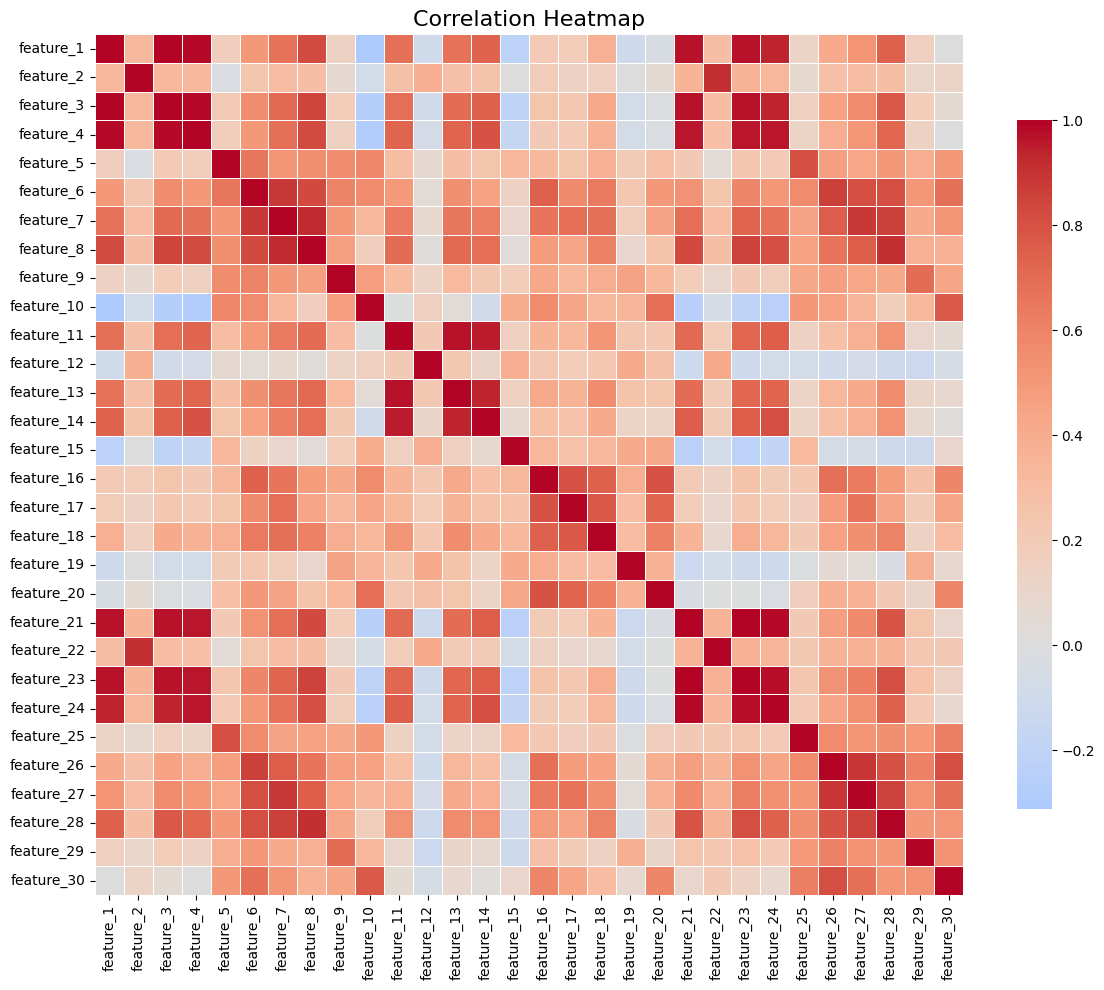

In [5]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X_scaled.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# Initialize dictionary to store selected features
feature_selection_results = {}

# Method 1: Correlation-based selection
correlation_threshold = 0.9
corr_matrix = X_scaled.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
correlation_features = [col for col in X_scaled.columns if col not in to_drop]
feature_selection_results['Correlation'] = correlation_features

# Method 2: Chi-Square
chi2_selector = SelectKBest(chi2, k=16)
chi2_selector.fit(X_scaled, y)
chi2_features = X_scaled.columns[chi2_selector.get_support()].tolist()
feature_selection_results['Chi2'] = chi2_features

# Method 3: RFE
rfe_selector = RFE(estimator=LogisticRegression(max_iter=5000), n_features_to_select=16)
rfe_selector.fit(X_scaled, y)
rfe_features = X_scaled.columns[rfe_selector.get_support()].tolist()
feature_selection_results['RFE'] = rfe_features

# Method 4: RFECV
rfecv_selector = RFECV(estimator=LogisticRegression(max_iter=5000), cv=5)
rfecv_selector.fit(X_scaled, y)
rfecv_features = X_scaled.columns[rfecv_selector.get_support()].tolist()
feature_selection_results['RFECV'] = rfecv_features

# Method 5: Random Forest importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_scaled, y)
rf_importances = pd.Series(rf_selector.feature_importances_, index=X_scaled.columns)
rf_features = rf_importances.nlargest(16).index.tolist()
feature_selection_results['RF'] = rf_features

# Method 6: Extra Trees importance
et_selector = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_selector.fit(X_scaled, y)
et_importances = pd.Series(et_selector.feature_importances_, index=X_scaled.columns)
et_features = et_importances.nlargest(16).index.tolist()
feature_selection_results['Extratrees'] = et_features

# Method 7: L1 (Lasso)
lasso_selector = Lasso(alpha=0.01, random_state=42)
lasso_selector.fit(X_scaled, y)
l1_features = X_scaled.columns[np.abs(lasso_selector.coef_) > 0].tolist()[:16]
feature_selection_results['L1'] = l1_features

# Voting-based feature selection
feature_votes = {}
for feature in X_scaled.columns:
    votes = sum([1 for method, features in feature_selection_results.items() if feature in features])
    feature_votes[feature] = votes

voted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)[:16]
voted_feature_names = [f[0] for f in voted_features]
feature_selection_results['Voted'] = voted_feature_names

print("Feature selection completed!")
print(f"Number of methods: {len(feature_selection_results)}")
print(f"\nVoted features ({len(voted_feature_names)}):")
for feature, votes in voted_features:
    print(f"  {feature}: {votes} votes")

Feature selection completed!
Number of methods: 8

Voted features (16):
  feature_1: 6 votes
  feature_7: 6 votes
  feature_8: 6 votes
  feature_11: 6 votes
  feature_21: 6 votes
  feature_22: 6 votes
  feature_27: 6 votes
  feature_28: 6 votes
  feature_2: 5 votes
  feature_3: 5 votes
  feature_4: 5 votes
  feature_23: 5 votes
  feature_24: 5 votes
  feature_25: 4 votes
  feature_26: 4 votes
  feature_6: 3 votes



Feature Selection Voting Table:
            Correlation  Chi2  RFE  RFECV  RF  Extratrees  L1  Voted  \
feature_1             1     1    1      1   1           1   0      1   
feature_7             1     1    1      1   1           1   0      1   
feature_8             0     1    1      1   1           1   1      1   
feature_11            1     1    1      1   1           1   0      1   
feature_22            0     1    1      1   1           1   1      1   
feature_21            0     1    1      1   1           1   1      1   
feature_28            0     1    1      1   1           1   1      1   
feature_27            1     1    1      1   1           1   0      1   
feature_23            0     1    1      1   1           1   0      1   
feature_24            0     1    1      1   1           1   0      1   
feature_4             0     1    1      1   1           1   0      1   
feature_2             1     0    1      1   1           1   0      1   
feature_3             0     1  

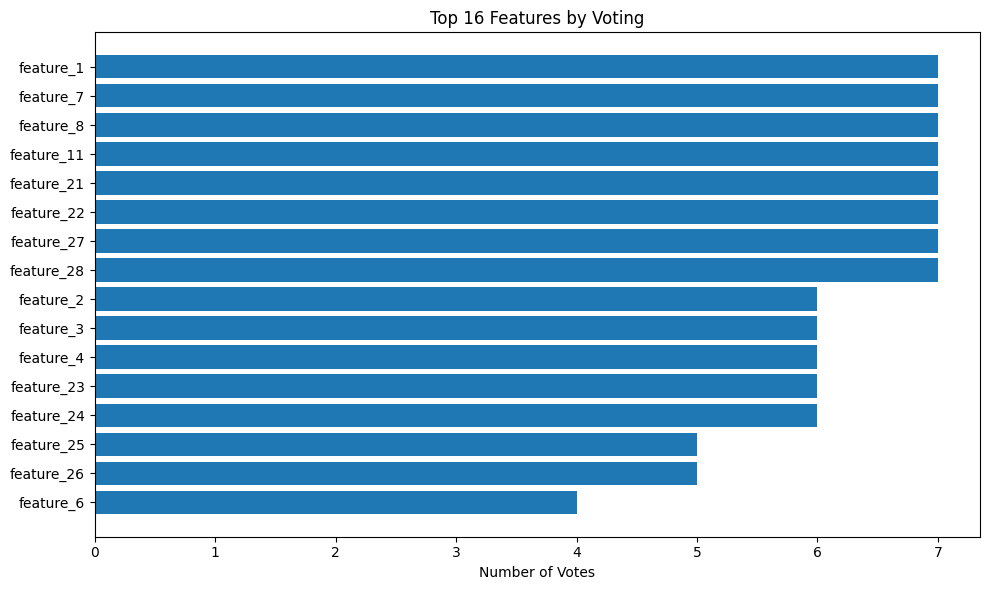

In [7]:
# Create voting table
voting_df = pd.DataFrame(index=X_scaled.columns)
for method, features in feature_selection_results.items():
    voting_df[method] = [1 if col in features else 0 for col in X_scaled.columns]

voting_df['Total_Votes'] = voting_df.sum(axis=1)
voting_df = voting_df.sort_values('Total_Votes', ascending=False)

print("\nFeature Selection Voting Table:")
print(voting_df.head(16))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(16), [voting_df.loc[f, 'Total_Votes'] for f in voted_feature_names])
plt.yticks(range(16), voted_feature_names)
plt.xlabel('Number of Votes')
plt.title('Top 16 Features by Voting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Use voted features
X_selected = X_scaled[voted_feature_names]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (455, 16)
Testing set size: (114, 16)


In [9]:
# Define models
models = {
    'LR': LogisticRegression(max_iter=5000, random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'ET': ExtraTreesClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(random_state=42),
    'NB': GaussianNB(),
    'GB': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate with 5-fold cross-validation
cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    accuracy = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=skf, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=skf, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1').mean()
    roc_auc = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc').mean()

    cv_results.append({
        'Algorithm': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc
    })

cv_results_df = pd.DataFrame(cv_results)
print("5-Fold Cross-Validation Results on Training Data:")
print(cv_results_df.round(4))

5-Fold Cross-Validation Results on Training Data:
  Algorithm  Accuracy  Precision  Recall      F1  ROC-AUC
0        LR    0.9582     0.9879  0.9000  0.9407   0.9903
1        RF    0.9670     0.9706  0.9412  0.9551   0.9848
2       SVM    0.9714     0.9941  0.9294  0.9602   0.9939
3        ET    0.9648     0.9761  0.9294  0.9518   0.9916
4       KNN    0.9626     0.9654  0.9353  0.9490   0.9847
5        DT    0.9429     0.9253  0.9235  0.9233   0.9390
6        NB    0.9451     0.9203  0.9353  0.9272   0.9838
7        GB    0.9692     0.9761  0.9412  0.9580   0.9910


In [10]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=5000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_

print("Best parameters for Logistic Regression:")
print(grid_search_lr.best_params_)
print(f"Best cross-validation ROC-AUC: {grid_search_lr.best_score_:.4f}")

Best parameters for Logistic Regression:
{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.9930


In [11]:
# Train all models on full training data and evaluate on test set
test_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    test_results.append({
        'Algorithm': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

# Best model evaluation
best_lr_model.fit(X_train, y_train)
y_pred_best = best_lr_model.predict(X_test)
y_pred_proba_best = best_lr_model.predict_proba(X_test)[:, 1]

test_results.append({
    'Algorithm': 'LR (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'F1': f1_score(y_test, y_pred_best),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_best)
})

test_results_df = pd.DataFrame(test_results)
print("\nTest Set Performance:")
print(test_results_df.round(4))


Test Set Performance:
    Algorithm  Accuracy  Precision  Recall      F1  ROC-AUC
0          LR    0.9649     1.0000  0.9048  0.9500   0.9980
1          RF    0.9737     1.0000  0.9286  0.9630   0.9939
2         SVM    0.9825     1.0000  0.9524  0.9756   0.9970
3          ET    0.9649     1.0000  0.9048  0.9500   0.9997
4         KNN    0.9737     1.0000  0.9286  0.9630   0.9969
5          DT    0.9123     0.9000  0.8571  0.8780   0.9008
6          NB    0.9474     0.9500  0.9048  0.9268   0.9937
7          GB    0.9649     1.0000  0.9048  0.9500   0.9974
8  LR (Tuned)    0.9737     0.9756  0.9524  0.9639   0.9983


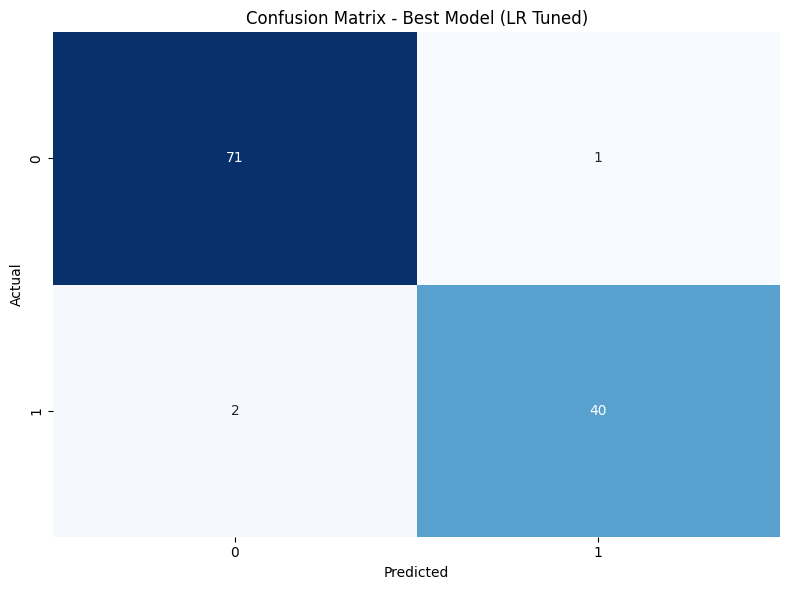


Confusion Matrix:
[[71  1]
 [ 2 40]]


In [12]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model (LR Tuned)')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:\n{cm}")

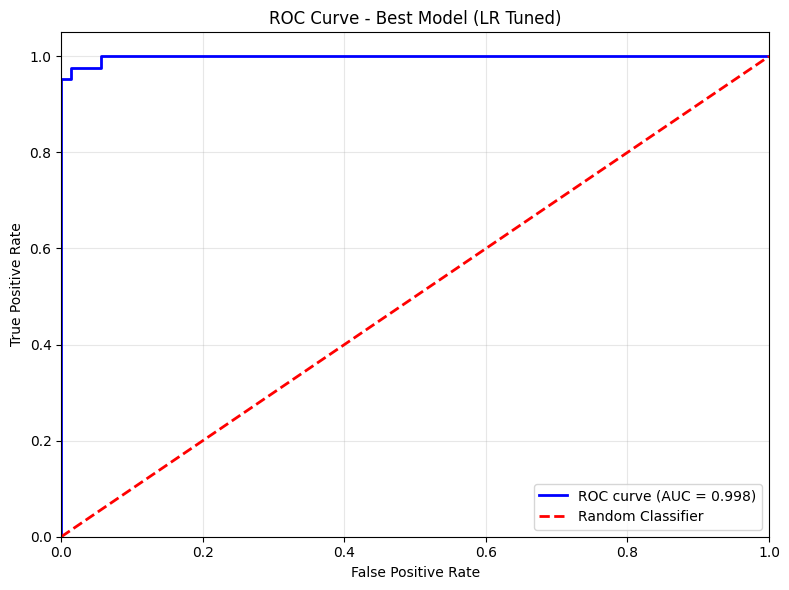

In [13]:
# ROC Curve for best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model (LR Tuned)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

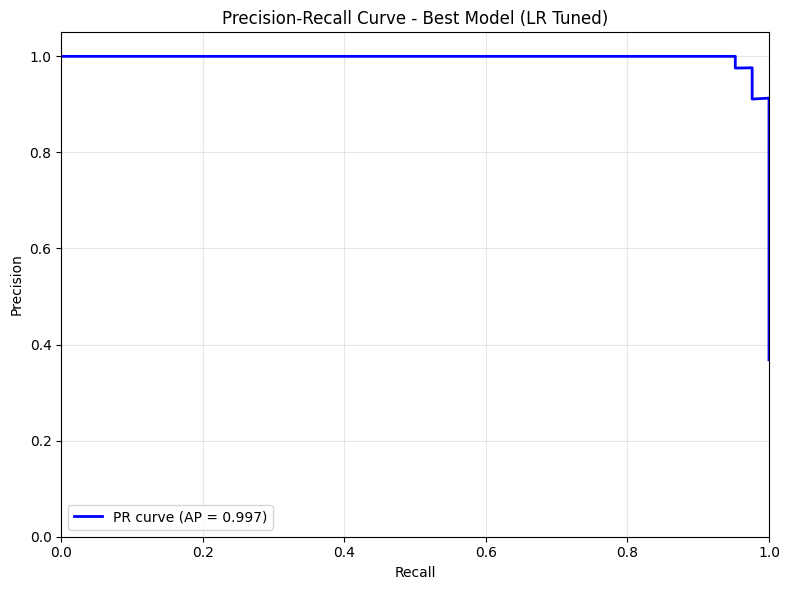

In [14]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model (LR Tuned)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

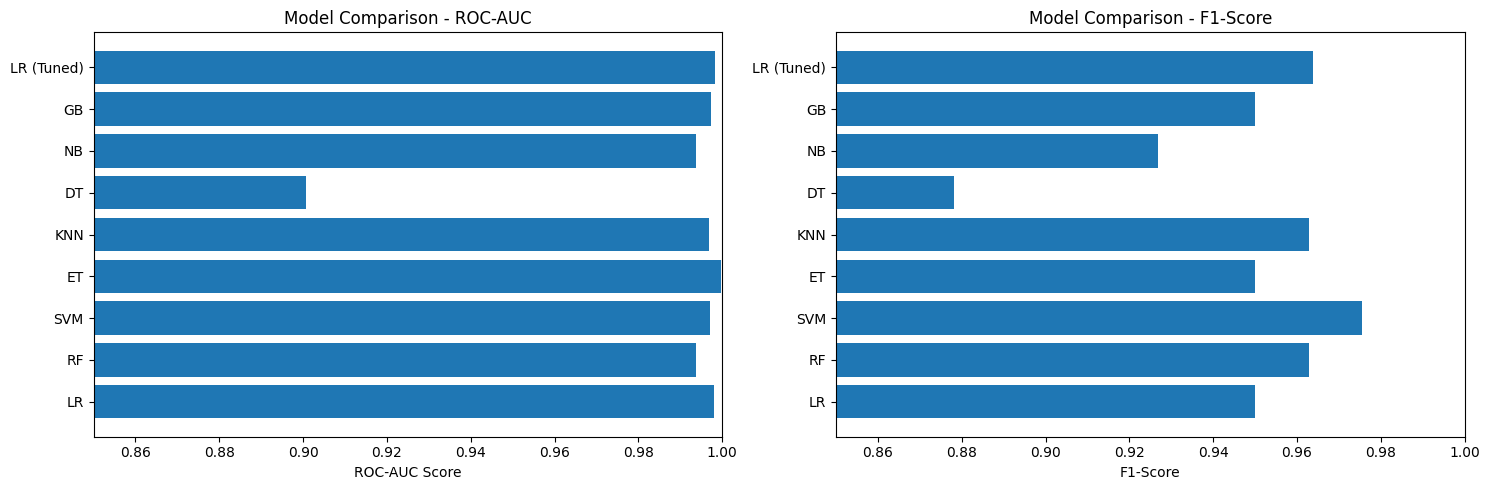

In [15]:
# Compare all models
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC-AUC comparison
axes[0].barh(test_results_df['Algorithm'], test_results_df['ROC-AUC'])
axes[0].set_xlabel('ROC-AUC Score')
axes[0].set_title('Model Comparison - ROC-AUC')
axes[0].set_xlim([0.85, 1.0])

# F1-Score comparison
axes[1].barh(test_results_df['Algorithm'], test_results_df['F1'])
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Model Comparison - F1-Score')
axes[1].set_xlim([0.85, 1.0])

plt.tight_layout()
plt.show()